<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU3Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting the probability you die at a given age**

To begin using python, we need to install the libraries we want to use if they arent already available. I dont strictly need preliz since I utimately use PyMc, but its nice to illustrate the graphs, so I'll install it.

In [ ]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


Import all of our wonderful libraries here. Arviz is used for analyzing our graphs and checking our posterior. Pymc is our engine of prediction. Numpy is a nice to have library and used for subsampling our 1.22 Million samples to run in reasonable times. Preliz just makes nice graphs of priors and likelyhoods so we can make good educated guesses.

In [ ]:
import arviz as az
import pymc as pm     #The engine of prediction
import numpy as np
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods

We need to open our file and use the csv library to quickly parse our file into a list of lists.

In [ ]:
import csv
with open('ages.csv',encoding = 'utf-8') as file:
  reader = csv.reader(file)
  data = list(reader)

Here we're using list comprehension to extract the 10th column from the table and converting those values to integers if they are not blank. Additionally we start on row 2 since the first row is the labels.

In [ ]:
#       add 1 since the number 0 breaks the model, column 10 (index 9) is age at death
ages = [1+int(data[i][9]) for i in range(1,len(data)) if data[i][9] != '']

Now since we have 1.22M values our model will take a very long time to train, so we shuffle the array and select the first 100K values to act as a representative sample.

In [ ]:
observed = np.array(ages)
np.random.shuffle(observed)
observed = observed[:100_000] #Slice off the first 100K
observed

array([33, 79, 67, ..., 55, 42, 61])

Now lets plot a histogram of our cumulative data and our represnetative data to make sure theres nothing too odd about it all.

(array([2.90000e+03, 4.59630e+04, 1.17694e+05, 3.14538e+05, 5.25415e+05,
        2.15489e+05, 9.77000e+02, 3.00000e+01, 1.00000e+00, 1.00000e+00]),
 array([  1. ,  17.9,  34.8,  51.7,  68.6,  85.5, 102.4, 119.3, 136.2,
        153.1, 170. ]),
 <BarContainer object of 10 artists>)

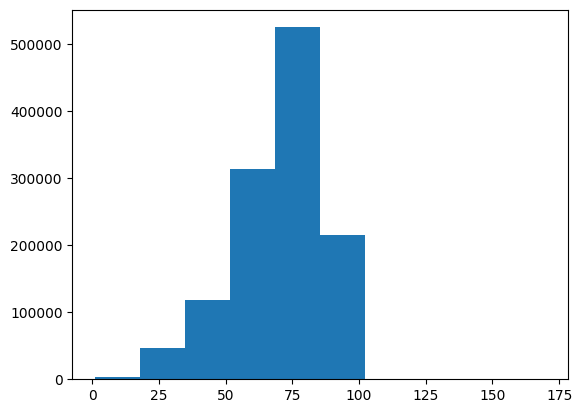

In [ ]:
import matplotlib as plt
plt.pyplot.hist(ages)

(array([1.240e+02, 1.636e+03, 4.718e+03, 8.952e+03, 1.948e+04, 3.482e+04,
        2.624e+04, 3.967e+03, 6.000e+01, 3.000e+00]),
 array([  1. ,  14.2,  27.4,  40.6,  53.8,  67. ,  80.2,  93.4, 106.6,
        119.8, 133. ]),
 <BarContainer object of 10 artists>)

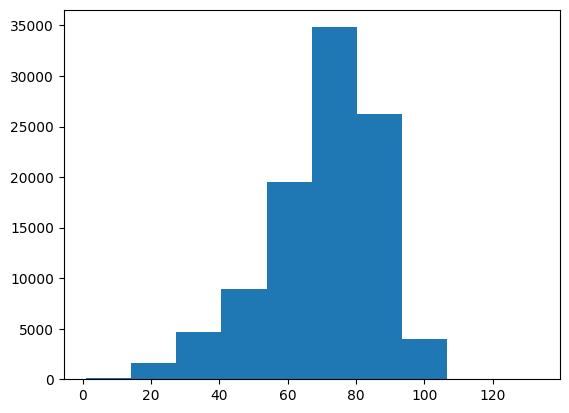

In [ ]:
plt.pyplot.hist(observed)

Looks about right, lets move onto picking our likelyhood function.
Our data seems to have a leftward skew and support from [0, $\infty$), so the Weibull distribution fits our needs. Looking at the definition for it, its defined as the probability of failure (or time till failure) for an event with a rate of failure that is a polynomial of time. This is all fancy way to say that it can model an exponential in the degenerate case or in our case it can model things with an increasing failure rate (like humans).

The two parameters we have then are alpha and beta, where alpha is the amount by which failure rate increases with time and beta is the scaling factor.

I played around with the parameters to get a graph that looks sort of like our data just as a sanity check to make sure this function seems fit to model our data.

<Axes: >

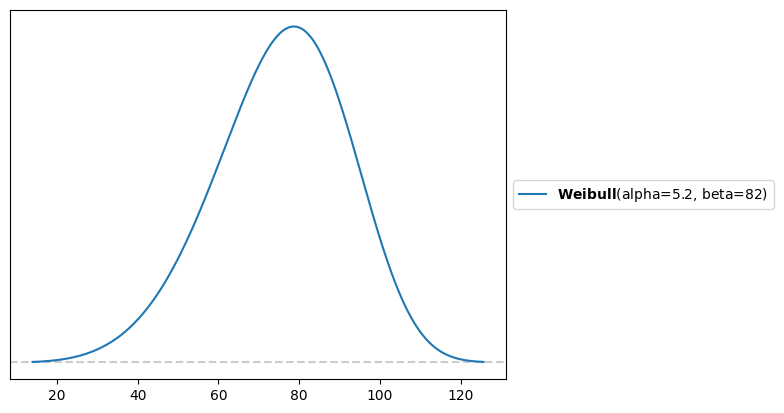

In [ ]:
pz.Weibull(alpha = 5.2, beta = 82).plot_pdf()

Now we need to decide upon our choice of prior functions.

Since our scaling factor is very close to the mean, I'll give it a gaussian distribution centered on about 70 as we expect the mean to be in this range.

Now since people tend to die very quickly past the age of 80, we're going to expect a quick fall off, or high power value, so I'll make the prior for our alpha parameter be a gamma curve with a mean about around 5. The means of these give a mean for our Weibull around 80 which is our mean age of death.
I choose a gamma distribution since it has posative support which is the range of values that make sense for humans and clusters around a value with a rightwards skew.

<Axes: >

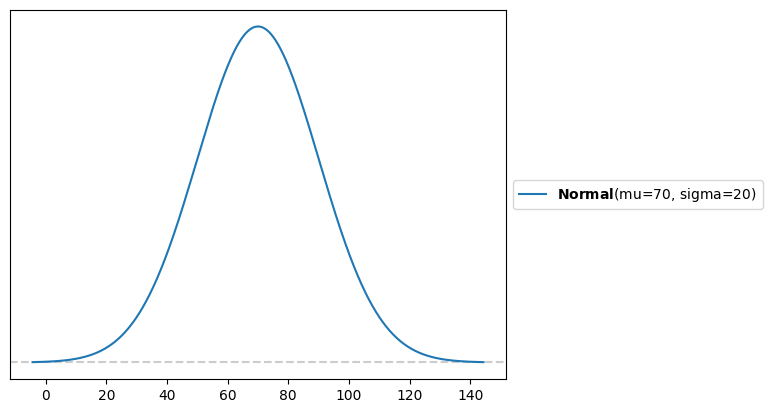

In [ ]:
pz.Normal(70, 20).plot_pdf()

<Axes: >

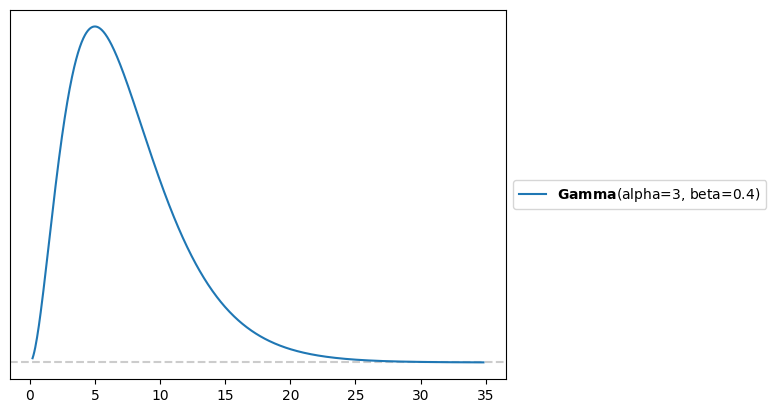

In [ ]:
pz.Gamma(3, .4).plot_pdf()

Take all these values and shove it into a predictive modeling function...

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 70, sigma = 20) #Using values derived above
  l = pm.Gamma('l', 3, .4)  #Using values from above

  y = pm.Weibull('y', alpha = l, beta = k, observed = observed)

  #Note, don't put 1000 in the first argument, causes issues maybe.
  samples = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78c0d72b95a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

And we have our model, now to use the code form the previous projects to get some inference data so we can graph it.

In [ ]:
pm.sample_posterior_predictive(samples, model=model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

And now we use Avriz's plot posterior predictive check and see how it looks!

<Axes: xlabel='y'>

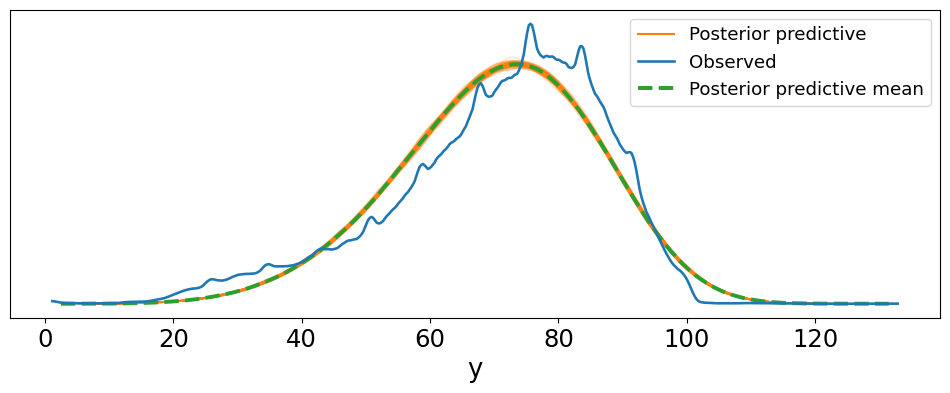

In [ ]:
az.plot_ppc(samples, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C2"])

Ahh, ok. Its a little bit spiky. I spent a good long time trying to figure this out but I could not for the life of me find out what these spikes are doing here. This project failed alot of times and my old data didnt have these, so I doubt its data processing, but there must be some anomilies in my choice of data which results in spikes. (I talk about problems with it later). For now lets analyze the solved parameters.

Also noteable here is how weirdly tight all of the posteriors are to the posterior mean. I've seen in alot of models that these "strands" tend to vary a bit and give the posterior a distinctive shape, but in mine they all seem to about run the same and follow a weibull curve tightly.

array([[<Axes: >, None],
       [<Axes: xlabel='k', ylabel='l'>, <Axes: >]], dtype=object)

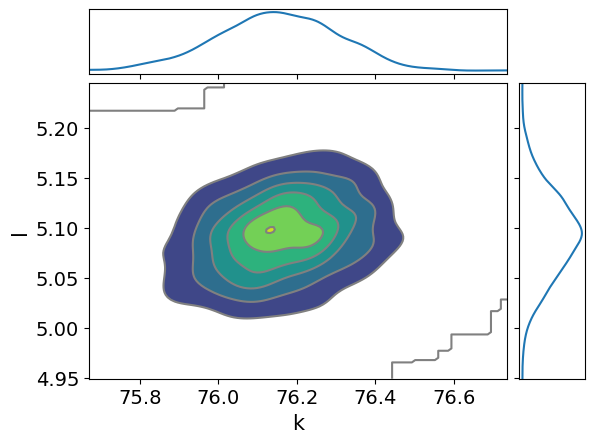

In [ ]:
az.plot_pair(samples, kind='kde', marginals=True)

array([<Axes: title={'center': 'k'}>, <Axes: title={'center': 'l'}>],
      dtype=object)

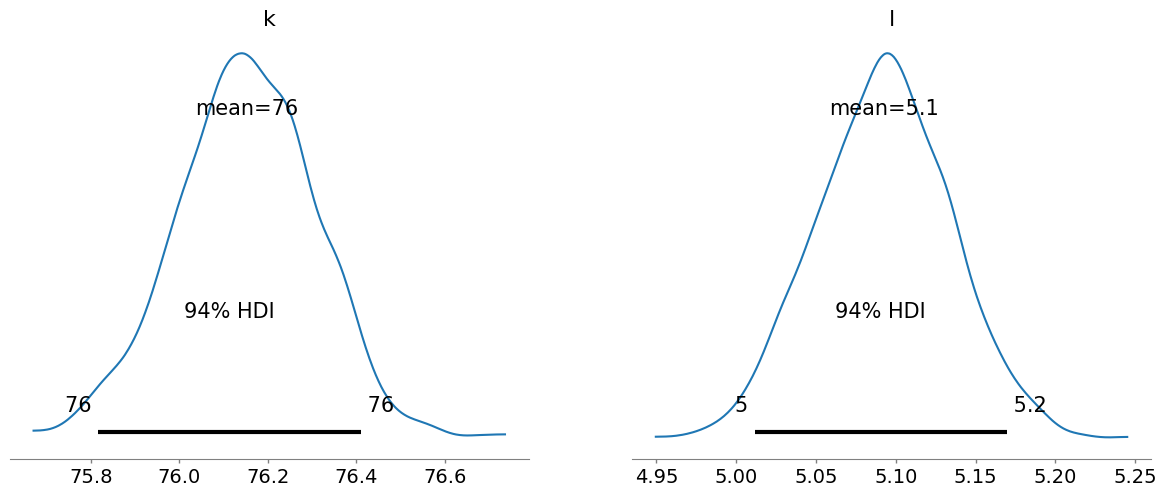

In [ ]:
az.plot_posterior(samples)

The HDI's on our samples here are super tight, alpha goes from 75.8 - 76.4, and beta from ~5.01 - ~5.17, these are very small and probably constitute the very similar posterior predictives.

Using the mean values for alpha and beta, we can use the formulaic mean to find our mean age of death

In [ ]:
alpha = 5.1
beta = 76
import math
mean = beta * math.gamma(1 + 1/alpha)
deviation = beta * beta * math.gamma(1 + 2/alpha - mean*mean/beta/beta)
mean, deviation

(69.8606469688105, 9380.483486886815)

In [ ]:
np.median(az.extract(samples, group="posterior_predictive").sel(sample=0).sel(draw=0).y.to_series()), np.median(observed)

(70.73723932987048, 73.0)

These turn out to be very close to our actually observed data, so in terms of mean and median its very close, and our graph was good enough for most purposes.

Now Imma quickly try and analyze what those spikes are to see if theres any tie between them and aligning nicely with ages.

In [ ]:
vs = np.sort(np.unique(observed)) #Filter our each unique death age
for v in vs:
  amt = np.sum(observed == v) #Number of instances equal to that
  pdiff = amt - np.sum(observed == v+1) #Compare to ages above
  ndiff = amt - np.sum(observed == v-1) #And below
  oddity = pdiff > 0 and ndiff > 0
  if oddity:
    print(v, amt, pdiff, ndiff)

1 21 12 21
7 7 3 5
10 3 1 1
13 21 1 5
23 171 7 14
26 255 3 48
32 330 2 4
34 383 10 55
37 415 9 7
41 539 66 89
44 617 44 80
47 706 14 64
51 890 76 115
66 2084 91 217
71 2468 11 156
75 2744 106 206
79 2722 79 3
81 2672 164 29
103 13 8 2
106 7 4 4
114 7 3 2
116 5 1 1
120 2 2 1
133 1 1 1


They do not, ok, I dont really wanna throw out all my data, but theres certainly some things that are messing it up and contaminating it. Here are some problems I think might impact it: \\
 * First, our data is of people considered "distinguished", this just means that they were noteable enough to be listed somewhere and then scraped and amagamated. This is going to mean that very young deaths are less likely as a young person is less likely to be distinguished than an old person. On that note, there are several people listed simply for being old, this includes a Henry Jankins, who claimed to live to 169 years old.
 * Second, our data while partially sanatized is not fully sanatized and there are several people listed who were note gaurnteed to exists and simply might've or probably didn't.
 * Our data is collected over varying time frames which means that while mean our age of death today is about 80-ish, in our data set its about 70 becuase of the number of old historic individuals who died young-ish. Also the data set includes a disporpottionate number of people who died in atypical ways which often tends to be younger.
 * As we saw, there is clearly some tendenices for ages. I couldn't find any immediate pattern upon first glance and tbh I suspect it has to be some odd data entry problem or the impact of global death events like wars or pandemics, but I cant say for sure.

# How I got my model to work

Attempt 1) CDC Data \\
Weibull from Normal + Gamma \\
In this model I got some data from the CDC for death rates by age, and this includes with it a set of expected number of people alive out of 100K at a given age. I initially took this number and turned it into deaths at an age in order to create data which would act like our posterior so it could change against. This turned out to be a major mistake and influenced litearly all of my models until this one

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 80, sigma = 20)
  l = pm.Gamma('l', 2, 1) #The power function on failure rate is like to be above 1, must be above 0, and likely to fall off for high values

  y = pm.Weibull('y', alpha = l, beta = k, observed = observed)

  samples = pm.sample(1000)

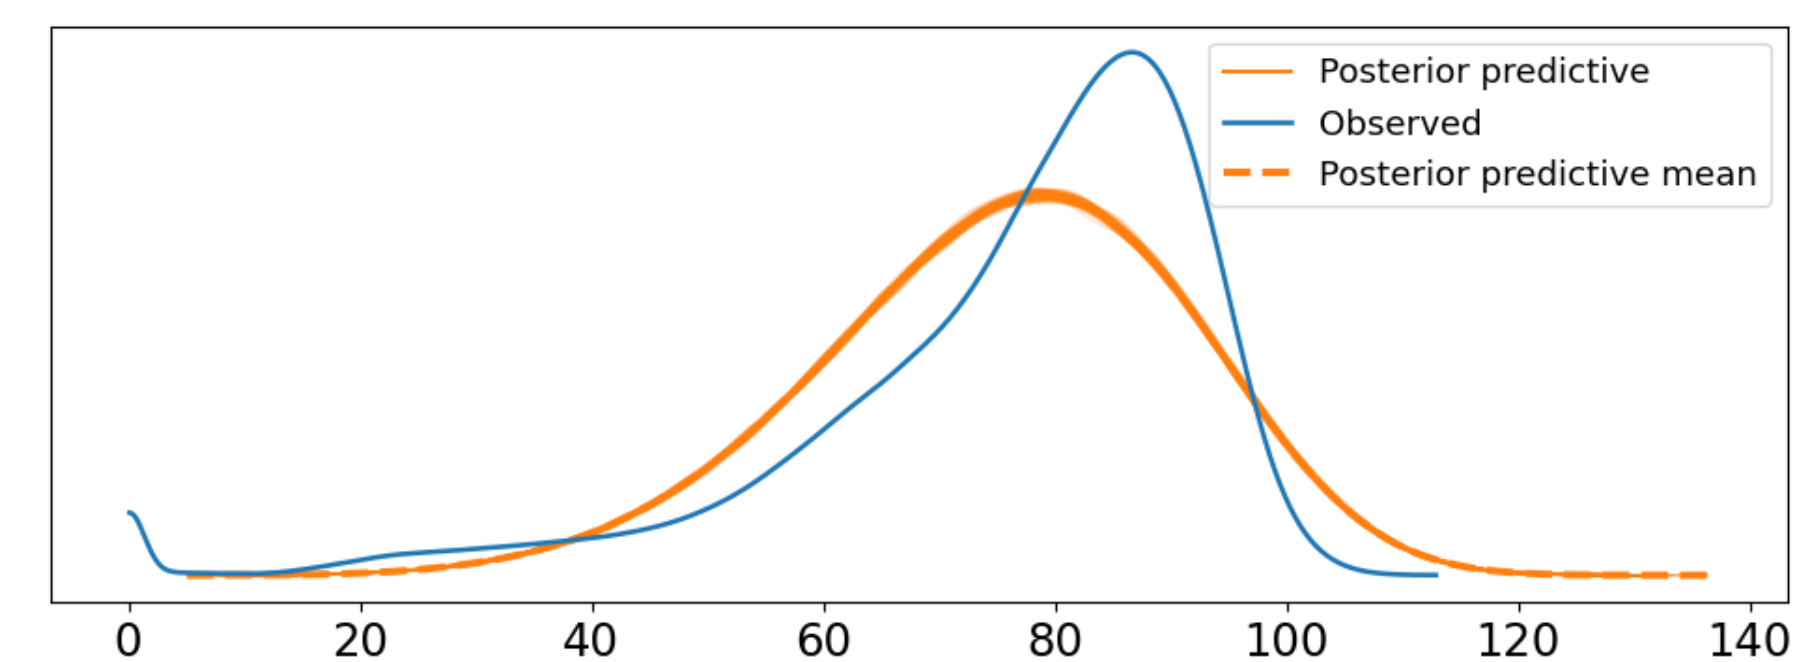

Attempt 2)

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 80, sigma = 30)
  l = pm.Gamma('l', 2, .7) #The power function on failure rate is like to be above 1, must be above 0, and likely to fall off for high values

  y = pm.Weibull('y', alpha = l, beta = k, observed = observed)

  samples = pm.sample(1000)

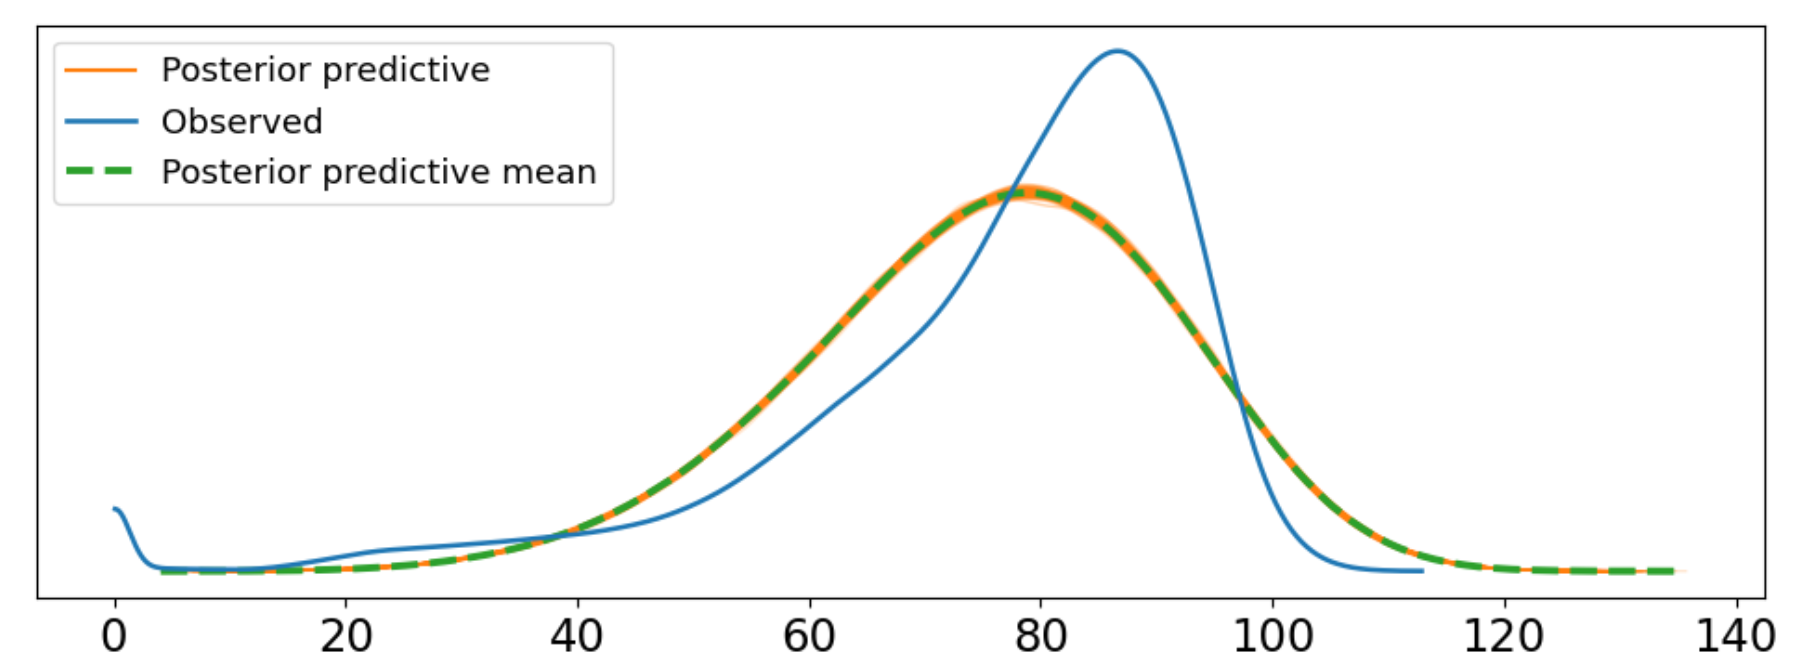

Attempt 3)

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 80, sigma = 30)
  l = pm.Gamma('l', 3, .5) #The power function on failure rate is like to be above 1, must be above 0, and likely to fall off for high values

  y = pm.Weibull('y', alpha = l, beta = k, observed = observed)

  samples = pm.sample(1000)

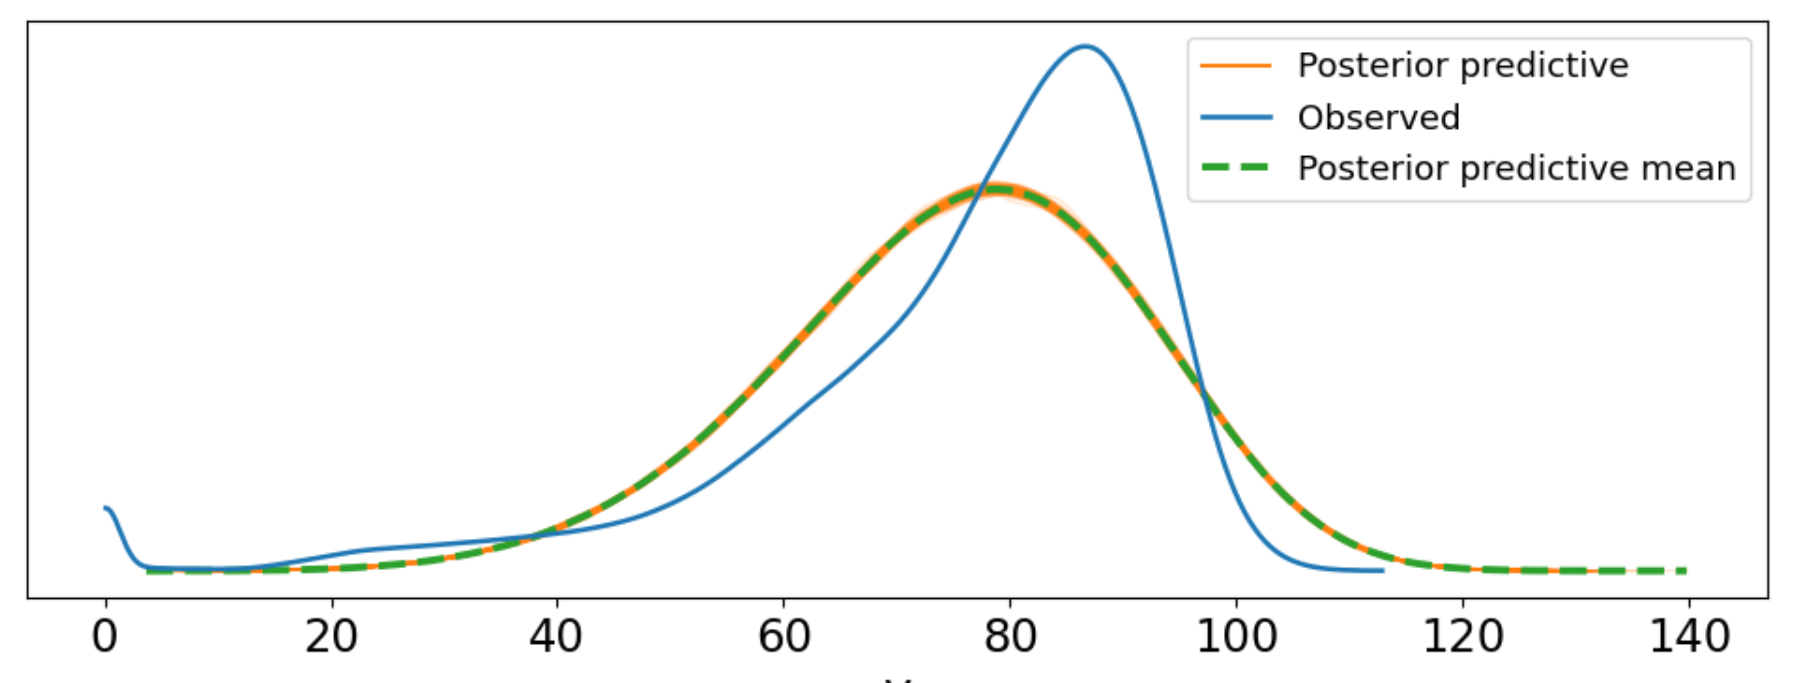

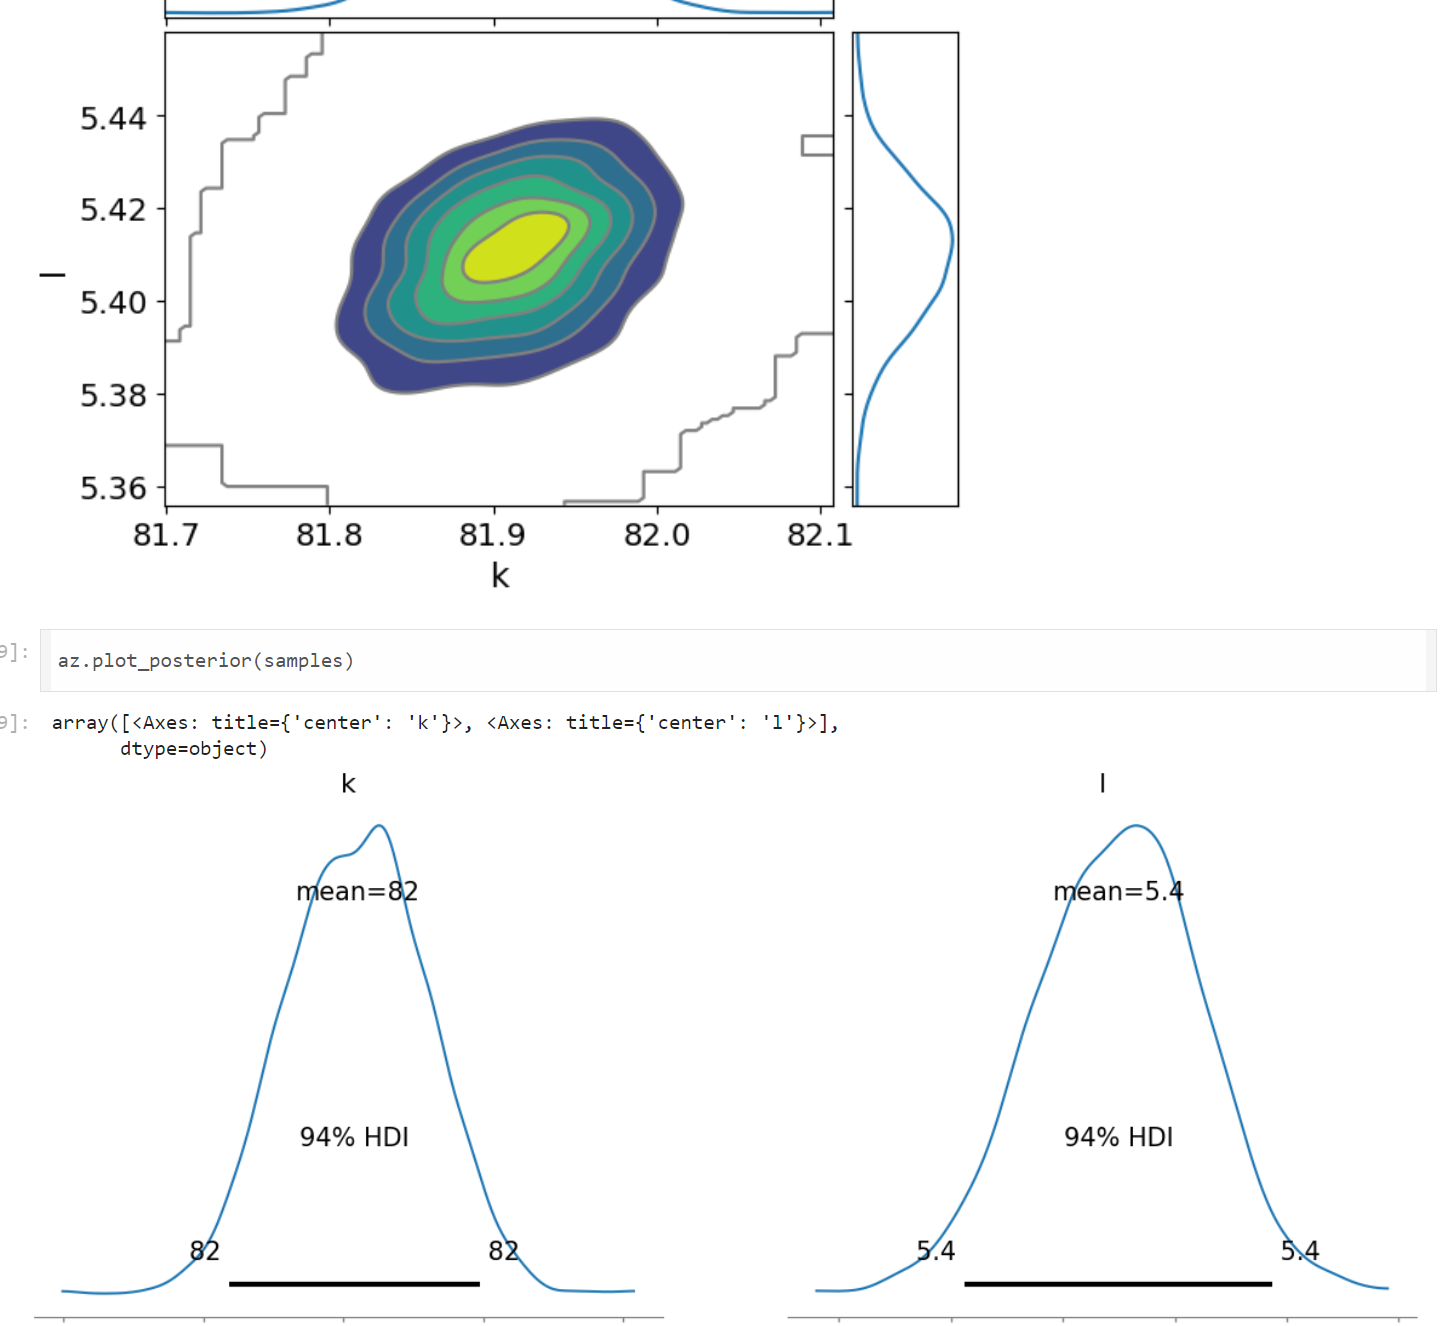

Attempt 4)

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 120, sigma = 40)
  l = pm.Gamma('l', 5, .2) #The power function on failure rate is like to be above 1, must be above 0, and likely to fall off for high values

  y = pm.Weibull('y', alpha = l, beta = k, observed = observed)

  samples = pm.sample()

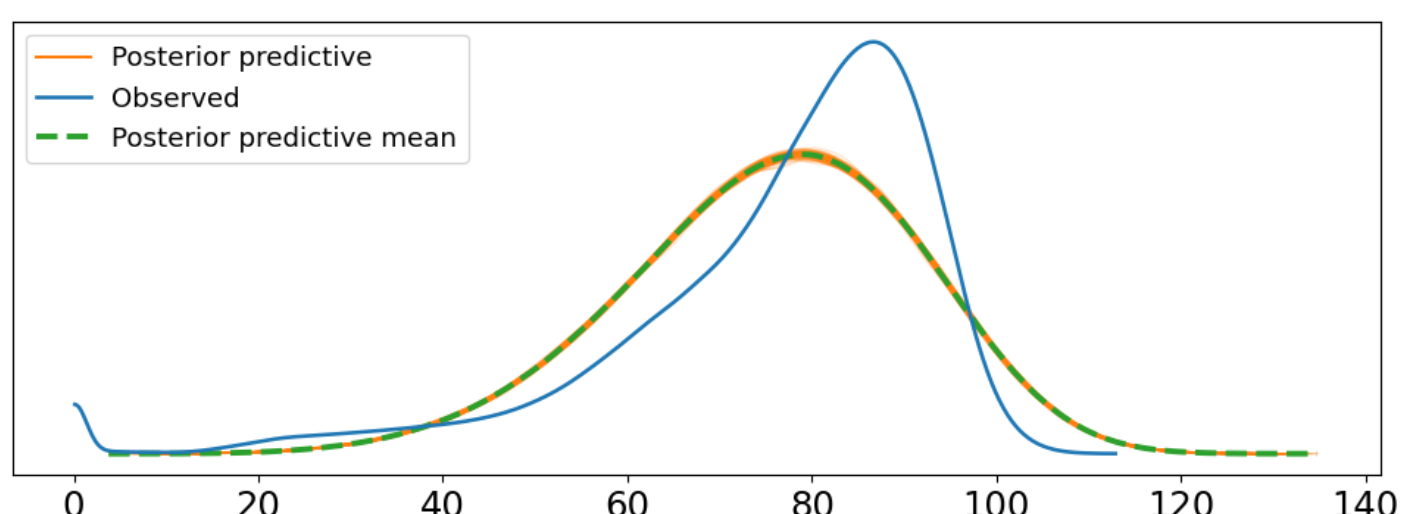

Attempt 5) \\
So fed up with the problems I tried using a normal curve and it still kept placeing the hump very off center.

In [ ]:
#Define our model using the python `with` syntax
with pm.Model() as model:
  k = pm.Normal('k', mu = 82, sigma = 20)
  l = pm.HalfNormal('l', sigma = 5)

  y = pm.Normal('y', mu = k, sigma = l, observed = observed)

  samples = pm.sample()

[link text](https://)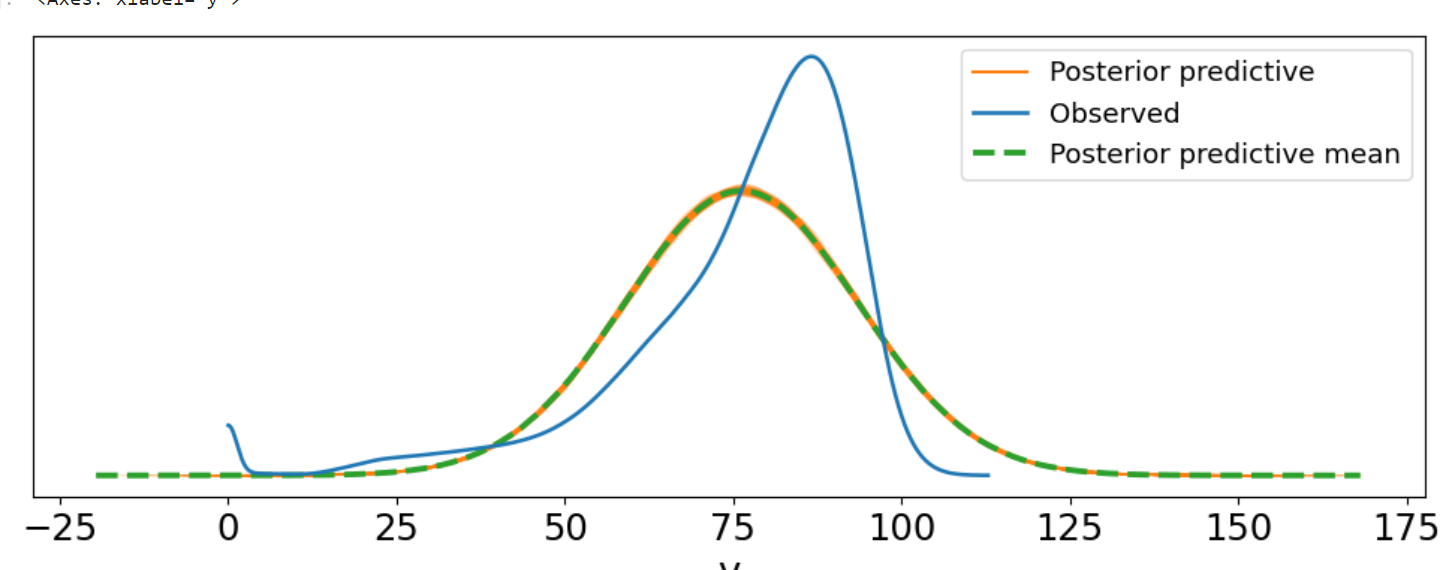

In general no matter what I did to the priors which made the model finish training (A few cases halted but did not terminate), I could not generate divergences nor any shape other than what was seen.

Ultimetaly after consulting with Mr. Arredondo, I decided to go get "real" data which worked much better, even if it has the problems I alluded to earlier